# Data Science Workflow

## Set Up the Jupyter Notebook for Analysis

Note: We have our package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install <br>

In [177]:
import getpass

# get cetificate
os.environ['CAS_CLIENT_SSL_CA_LIST'] ='/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem'

# credentials
host = 'tenant1.vi-sg.sg.com'
port = 19013
username = 'viadmin'
password = getpass.getpass()

 ········


## Connect to the server

In [47]:
import swat

# Connect to CAS server
s = swat.CAS(host, port, username, password)

# Define caslib
s.sessionprop.setsessopt(caslib='public')

NOTE: 'Public' is now the active caslib.


+ Elapsed: 0.000431s, user: 0.000349s, mem: 0.256mb

## Access Data from SAS Platform

In [48]:
# data file
indata = 'large_cash_dep_alerts_modeling'
op = s.table.loadTable(path=str(indata).upper()+".sashdat", casout={"name":indata, "replace":True})

# CASTable view
castbl = s.CASTable(indata)

NOTE: Cloud Analytic Services made the file LARGE_CASH_DEP_ALERTS_MODELING.sashdat available as table LARGE_CASH_DEP_ALERTS_MODELING in caslib Public.


# Local data analysis

In [49]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Exploration and Preparation - Local

In [50]:
# Bring data locally
df = castbl.to_frame()

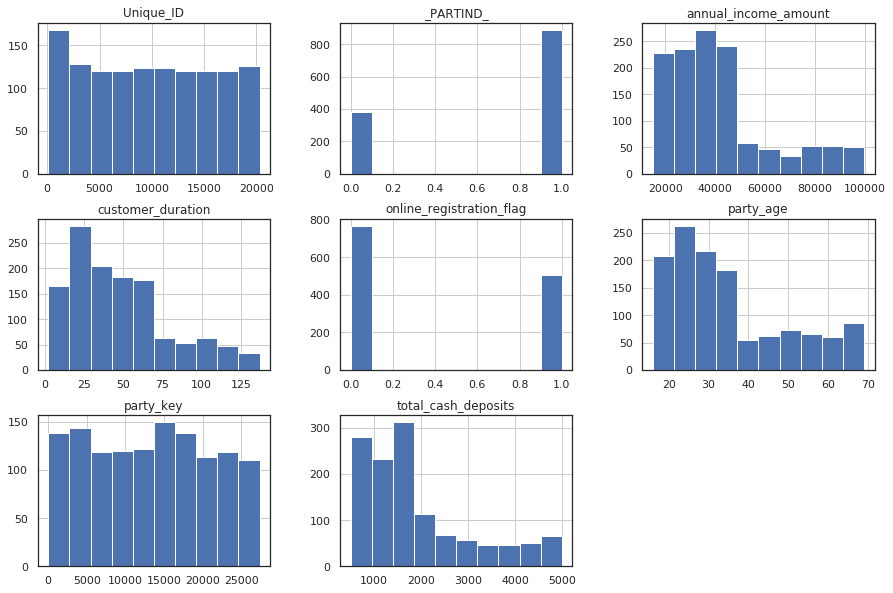

In [51]:
hists = df.hist(figsize = (15, 10))

### set variable shortcuts

In [138]:
# Define target variable
target = 'productive_flag'
id_col = 'Unique_ID'

# get categorical/numerical variables
input_vars = df.drop(target,axis=1).columns.values
kinds = np.array([dt.kind for dt in df.drop(target,axis=1).dtypes])

# Variable lists
categorical_vars = list(input_vars[kinds == 'O'])
numerical_vars = [i for i in list(input_vars[kinds != 'O']) if i not in [id_col,'_PARTIND_']]
input_vars = categorical_vars + numerical_vars
all_vars = categorical_vars + numerical_vars + [target]

### Prepare data for model

In [139]:
# Split into training and validation / target and inputs
X_train = df[df['_PARTIND_'] == 1][input_vars]
X_valid = df[df['_PARTIND_'] == 0][input_vars]
y_train = df[df['_PARTIND_'] == 1][target]
y_valid = df[df['_PARTIND_'] == 0][target]

## Build model - Scikit-learn

In [142]:
# Define data pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars)])

ml_pipe = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier(random_state=3))])

fit = ml_pipe.fit(X_train, y_train)

### Assess model

In [143]:
# put results in pandas dataframe
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# Predict and assess model
gb_y_score           = ml_pipe.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

# Add Python model results to CAS to assess
pytbl = s.upload_frame(results_df, casout=dict(name='GBT_sklearn_predictions', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GBT_SKLEARN_PREDICTIONS in caslib Public.
NOTE: The table GBT_SKLEARN_PREDICTIONS has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [144]:
gb_misclassification

0.03947368421052633

# Data Analysis on CAS

In [145]:
# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'regression', 'neuralNet', 'svm', 'astore','autotune']
actions = [s.loadactionset(i) for i in actionsets]

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.


## Data Exploration and Preparation - CAS

In [146]:
castbl.head()

,Unique_ID,productive_flag,party_key,party_gender,residence_country_name,employee_ind,occupation_desc,annual_income_amount,politically_exposed_person_ind,party_risk_class,online_registration_flag,total_cash_deposits,customer_duration,party_age,_PARTIND_
0,101.0,0,17196.0,F,FRANCE,N,SELF EMPLOYED CLERICAL,32542.0,N,Medium,0.0,1400.0,97.0,46.0,1.0
1,201.0,0,17241.0,M,FRANCE,N,MILITARY,45181.0,N,High,1.0,4610.0,28.0,21.0,1.0
2,301.0,0,17244.0,M,FRANCE,N,FARMER,89147.0,N,High,0.0,1300.0,9.0,23.0,1.0
3,401.0,0,17266.0,M,FRANCE,N,PROFESSIONAL,92099.0,N,Medium,0.0,1300.0,42.0,21.0,0.0
4,501.0,0,17282.0,U,FRANCE,N,FARMER,90079.0,N,Low,1.0,4870.0,52.0,28.0,0.0


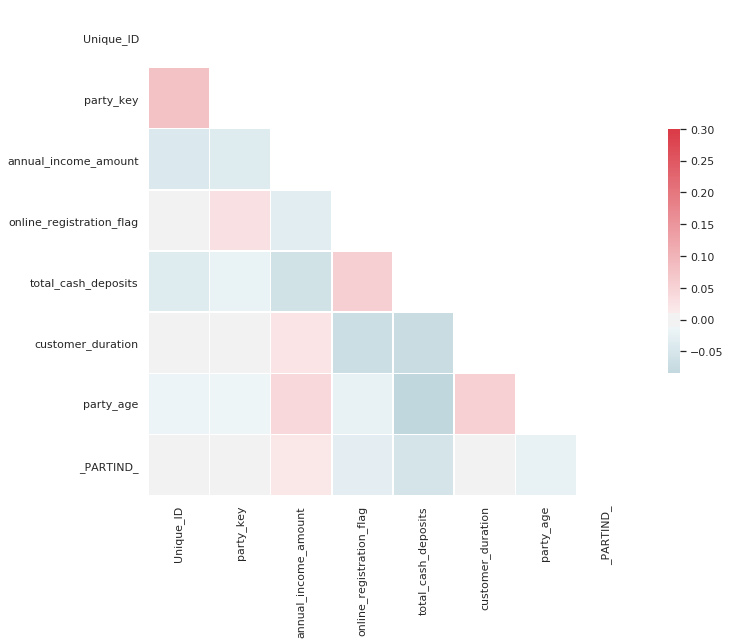

In [147]:
# Compute correlation matrix
corr = castbl.corr()

# Visualize with Seaborn
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build models - CAS

In [148]:
import collections

# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
models['svm'] = 'Support Vector Machine'

# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = categorical_vars + numerical_vars,
    copyAllVars       = True,
    casOut            = dict(name = 'hmeq_imputed', replace = True)
)
castbl_imp = s.CASTable('hmeq_imputed')

# Set key-word argument shortcuts (common model inputs)
## For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = indata, where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = categorical_vars + numerical_vars, 
    nominals = categorical_vars,
)

## For models that can't have missing values (neural network, support vector machine)
casinfo = castbl_imp.columninfo()['ColumnInfo']
imp_params = dict(
    table    = dict(name = 'hmeq_imputed', where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = [x for x in list(casinfo['Column']) if x != target and ('IMP_' in x)], 
    nominals = [x for x in list(casinfo[(casinfo.Type == 'varchar') | (casinfo.Type == 'char')]['Column']) if x != target and ('IMP' in x)],
)

### Decision Tree - CAS

In [149]:
dt = s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

### Gradient Boosting - CAS

In [150]:
gbt = s.decisionTree.gbtreeTrain(**params, seed = 1, casOut = dict(name = 'gbt_model', replace = True), saveState=dict(name = 'gradboost_model', replace = True))

NOTE: 767883 bytes were written to the table "gradboost_model" in the caslib "Public".


### Neural Network - CAS

In [151]:
nn = s.neuralNet.annTrain(**imp_params, seed = 1, casOut = dict(name = 'nn_model', replace = True))

### Support Vector Machine - CAS

In [152]:
svm = s.svm.svmTrain(**imp_params, seed = 1, kernel = 'polynomial', printtarget=True, id = ['_PARTIND_', id_col], savestate = dict(name = 'svm_model', replace = True))

NOTE: Reset degree to 2 for polynomial kernel.
NOTE: SVM training is activated.
NOTE: 16923 bytes were written to the table "svm_model" in the caslib "Public".


# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [153]:
def score_model(model):
    score = dict(
        table      = 'hmeq_imputed',
        modelTable = model + '_model',
        copyVars   = [target, '_PARTIND_'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))
### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))
### Neural Network
s.neuralNet.annScore(**score_model('nn'))
### Support Vector Machine
res = castbl_imp.astore.score(rstore = 'svm_model', out = dict(name = '_scored_svm_1', replace = True))

### Create standardized prediction column
for i in range(len(models)-1):
    s.dataStep.runCode('''
        data _scored_''' + list(models)[i] + '''; 
            set _scored_''' + list(models)[i] + ''';
            if _''' + list(models)[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
        run;
    ''')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 16 times)
      0:69  (occurred 16 times)
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:71
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 16 times)
      0:71  (occurred 16 times)
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 16 times)
      0:69  (occurred 16 times)


In [154]:
joined = s.CASTable('_scored_svm_1').merge(castbl_imp[[id_col,target]],on=id_col)

In [156]:
#s.dropTable('_scored_svm')
s.table.altertable(name = joined.name, rename='_scored_svm')

NOTE: Cloud Analytic Services dropped table _scored_svm from caslib Public.


+ Elapsed: 0.000376s, user: 0.000309s, mem: 0.284mb

## Assess the Performance - CAS/Python

In [157]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_PARTIND_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

## Compare Misclassification & ROC Curves - CAS/Python

In [158]:
# Assess the Python model using CAS
python_assess = pytbl.percentile.assess(
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model'] = 'Gradient Boosting - sklearn'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df, python_assess.ROCInfo])
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
1,Gradient Boosting - CAS,0.034211
2,Neural Network - CAS,0.036842
4,Gradient Boosting - sklearn,0.039474
3,Support Vector Machine - CAS,0.060526
0,Decision Tree - CAS,0.071053


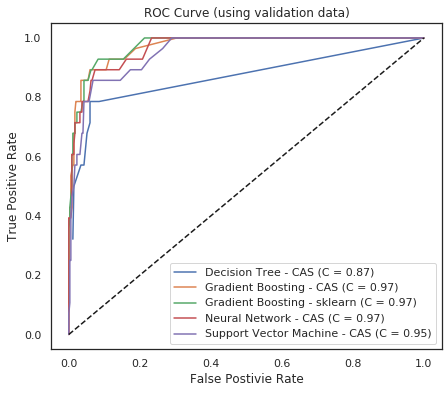

In [159]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');

## Automated Machine Learning

## AutoML - CAS

In [71]:
s.loadactionset('dataSciencePilot')
trans_out = dict(name = 'trans_out', replace=True)
feat_out = dict(name = 'feat_out', replace=True)
pipeline_out = dict(name = 'pipeline_out', replace=True)
#save_state_out = dict(name = 'save_state_out', replace=True)
automl_model = dict(name = 'automl_model', replace=True) 

NOTE: Added action set 'dataSciencePilot'.


In [191]:
s.dataSciencePilot.dsAutoMl(table=castbl, target=target,
                            modelTypes=["DECISIONTREE", "FOREST", "GRADBOOST", "NEURALNET"], 
                            transformationOut = trans_out,
                            featureOut = feat_out,
                            pipelineOut = pipeline_out,
                            saveState = automl_model)

NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.


,Descr,Value
0,Number of Tree Nodes,23.000000
1,Max Number of Branches,2.000000
2,Number of Levels,5.000000
3,Number of Leaves,12.000000
4,Number of Bins,100.000000
5,Minimum Size of Leaves,12.000000
6,Maximum Size of Leaves,707.000000
7,Number of Variables,10.000000
8,Confidence Level for Pruning,0.250000
9,Number of Observations Used,1268.000000


In [192]:
s.fetch(table='pipeline_out', to=3)

,PipelineId,ModelType,MLType,Objective,ObjectiveType,Target,NFeatures,Feat1Id,Feat1IsNom,Feat2Id,...,Feat8Id,Feat8IsNom,Feat9Id,Feat9IsNom,Feat10Id,Feat10IsNom,Feat11Id,Feat11IsNom,Feat12Id,Feat12IsNom
0,6.0,binary classification,forest,0.036842,MCE,productive_flag,10.0,20.0,1.0,17.0,...,4.0,0.0,18.0,1.0,19.0,1.0,NaN,NaN,NaN,NaN
1,7.0,binary classification,gradBoost,0.036842,MCE,productive_flag,10.0,20.0,1.0,17.0,...,4.0,0.0,18.0,1.0,19.0,1.0,NaN,NaN,NaN,NaN
2,10.0,binary classification,forest,0.044737,MCE,productive_flag,10.0,20.0,1.0,17.0,...,4.0,0.0,18.0,1.0,19.0,1.0,NaN,NaN,NaN,NaN


# Register Model

In [72]:
import os
import sasctl
import sasctl.pzmm as pzmm

from pathlib import Path

## Add model to repository - CAS

In [75]:
from sasctl import Session
from sasctl.tasks import register_model

astore = s.CASTable('gradboost_model')
with Session(host, username, password):
    register_model(astore, 'Jupyter Viya GBT', 'OS & Viya models', version='latest')

NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _CA11C7F61A0747D89BDAA130D.sashdat in caslib ModelStore.


## Add model to repository - sklearn

In [189]:
model = ml_pipe
models_path = 'models'
modelPrefix = 'Jupyter Sklearn GBT'
modelType='Pipeline Gradient Boosting'
model_path = models_path + '/' + modelPrefix
y_pred = results_df['pred']
targetValue = 1

In [190]:
# initiate folder

zipFolder = os.path.join(os.getcwd(), model_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)

pzmm.PickleModel.pickleTrainedModel(None, model, modelPrefix, zipFolder)

# Metadata files

JSONFiles = pzmm.JSONFiles()

JSONFiles.writeVarJSON(df[input_vars], isInput=True, jPath=zipFolder)

outputVar = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar['EM_CLASSIFICATION'] = y_train.astype('category').cat.categories.astype('str')
outputVar['EM_EVENTPROBABILITY'] = 0.5

JSONFiles.writeVarJSON(outputVar, isInput=False, jPath=zipFolder)

modelName = modelPrefix
JSONFiles.writeModelPropertiesJSON(modelName=modelName,
                                   modelDesc='',
                                   targetVariable=target,
                                   modelType=modelType,
                                   modelPredictors=input_vars,
                                   targetEvent=targetValue,
                                   numTargetCategories=1,
                                   eventProbVar='EM_EVENTPROBABILITY',
                                   jPath=zipFolder,
                                   modeler='sasdemo')

JSONFiles.writeFileMetadataJSON(modelPrefix, jPath=zipFolder)

# Evaluation data 

data = [(None, None),
        (np.array(y_valid.astype(int)), np.array(y_pred)),
        (None, None)]
JSONFiles = pzmm.JSONFiles()
JSONFiles.calculateFitStat(data, zipFolder)
JSONFiles.generateROCStat(data, target, zipFolder)
JSONFiles.generateLiftStat(data, target, targetValue, zipFolder)

# Score code
zipFolder = Path.cwd() / model_path

ScoreCode = pzmm.ScoreCode()
ScoreCode.writeScoreCode(df[input_vars], df[target].astype(int), modelPrefix,
                         '{}.predict({})', modelPrefix + '.pickle',
                         pyPath=zipFolder)

#Zip folder
pzmm.ZipModel.zipFiles(None,fileDir=zipFolder, modelPrefix=modelPrefix)

In [191]:
ModelImport = pzmm.ModelImport(host)

zPath = Path(zipFolder) / (modelPrefix + '.zip')
ModelImport.importModel(modelPrefix,
                        projectID='a1018b3f-a10b-42d9-873a-34cfc65a20f7',
                        zPath=zPath)

Enter user name: viadmin
Enter password for viadmin: ········
